<a href="https://colab.research.google.com/github/JoaoConrado/TRABALHO-2-IA/blob/main/Trabalho_2_Jo%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
#libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from imblearn.over_sampling import SMOTE
from tensorflow.keras.optimizers import Adam

Valores faltantes por coluna:
 Timestamp                     0
Source IP Address             0
Destination IP Address        0
Source Port                   0
Destination Port              0
Protocol                      0
Packet Length                 0
Packet Type                   0
Traffic Type                  0
Payload Data                  0
Malware Indicators        20000
Anomaly Scores                0
Alerts/Warnings           20067
Attack Type                   0
Attack Signature              0
Action Taken                  0
Severity Level                0
User Information              0
Device Information            0
Network Segment               0
Geo-location Data             0
Proxy Information         19851
Firewall Logs             19961
IDS/IPS Alerts            20050
Log Source                    0
dtype: int64


<ipython-input-50-0ab68a5c1d1e>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mode()[0], inplace=True)
<ipython-input-50-0ab68a5c1d1e>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

Número de outliers detectados: 40000


<ipython-input-50-0ab68a5c1d1e>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '32970.35645' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[outliers, col] = mean_vector[col]
<ipython-input-50-0ab68a5c1d1e>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '33150.86865' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[outliers, col] = mean_vector[col]
<ipython-input-50-0ab68a5c1d1e>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '781.452725' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[outliers, col] = mean_vector[col]


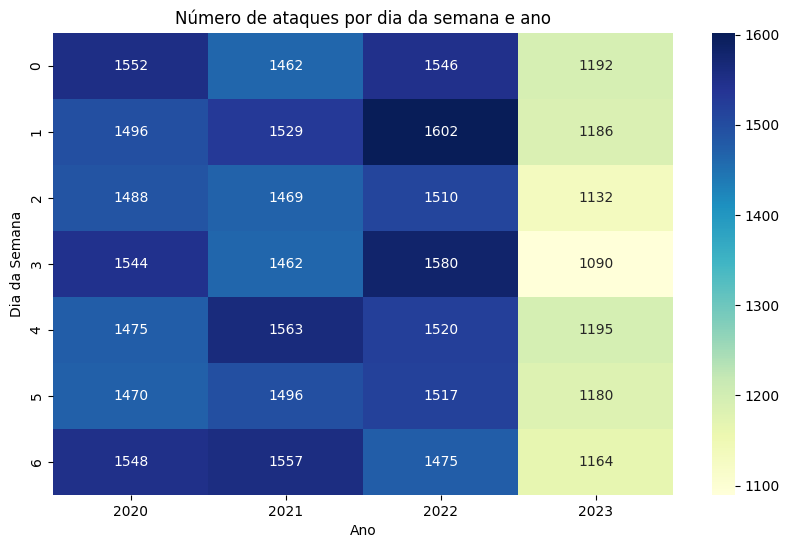

Distribuição de 'Severity Level':
Severity Level
1    13435
2    13382
0    13183
Name: count, dtype: int64


In [50]:
# Carregar a base de dados
data = pd.read_csv('/cybersecurity_attacks.csv')

# a) Análise e preparação dos dados
# Converter 'Timestamp' para datetime
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Verificar valores faltantes
missing_values = data.isnull().sum()
print("Valores faltantes por coluna:\n", missing_values)

# Tratamento de valores faltantes
for col in data.columns:
    if data[col].dtype in ['int64', 'float64']:
        data[col].fillna(data[col].median(), inplace=True)
    elif data[col].dtype == 'object':
        data[col].fillna(data[col].mode()[0], inplace=True)

# Detecção e tratamento de outliers
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
mean_vector = data[numeric_cols].mean()
threshold = 3  # Definido arbitrariamente

data['Euclidean_Distance'] = cdist(data[numeric_cols], [mean_vector], metric='euclidean')
outliers = data['Euclidean_Distance'] > threshold
print(f"Número de outliers detectados: {outliers.sum()}")

# Substituir outliers pelos valores médios
for col in numeric_cols:
    data.loc[outliers, col] = mean_vector[col]

# Remover a coluna auxiliar 'Euclidean_Distance'
data.drop(columns=['Euclidean_Distance'], inplace=True)

# b) HeatMap de correlação: Número de ataques por dia da semana e ano
data['DayOfWeek'] = data['Timestamp'].dt.dayofweek
data['Year'] = data['Timestamp'].dt.year

heatmap_data = pd.crosstab(data['DayOfWeek'], data['Year'])
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Número de ataques por dia da semana e ano')
plt.xlabel('Ano')
plt.ylabel('Dia da Semana')
plt.show()

# c) Divisão dos dados e treinamento com Redes Neurais
# Variável alvo
target = 'Severity Level'
data[target] = pd.factorize(data[target])[0]  # Transformar em valores numéricos

# Seleção de variáveis preditoras
features = [col for col in data.columns if col not in ['Severity Level', 'Timestamp', 'DayOfWeek', 'Year']]
X = data[features].select_dtypes(include=['float64', 'int64'])
y = data[target]

# Verificar balanceamento da variável alvo
print("Distribuição de 'Severity Level':")
print(data[target].value_counts())

# Aplicar SMOTE para balanceamento
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)

# Escalonamento
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [54]:
# Função para criar e treinar um modelo de rede neural ajustado
def create_nn_model(input_dim, layers, dropouts, learning_rate):
    model = Sequential()
    for i, layer_size in enumerate(layers):
        if i == 0:
            model.add(Dense(layer_size, activation='relu', input_dim=input_dim))
        else:
            model.add(Dense(layer_size, activation='relu'))
        if dropouts[i] > 0:
            model.add(Dropout(dropouts[i]))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Testar 3 topologias com taxa de aprendizado ajustada
topologies = [
    {'layers': [32, 16], 'dropouts': [0.2, 0.1], 'learning_rate': 0.01},
    {'layers': [64, 32, 16], 'dropouts': [0.3, 0.2, 0.1], 'learning_rate': 0.005},
    {'layers': [128, 64, 32, 16], 'dropouts': [0.4, 0.3, 0.2, 0.1], 'learning_rate': 0.001}
]

In [58]:
results = []
for i, topo in enumerate(topologies):
    print(f"Treinando Topologia {i+1}...")
    model = create_nn_model(
        input_dim=X_train_scaled.shape[1],
        layers=topo['layers'],
        dropouts=topo['dropouts'],
        learning_rate=topo['learning_rate']
    )
    model.fit(X_train_scaled, y_train, epochs=50, batch_size=50, verbose=1, validation_data=(X_test_scaled, y_test))
    y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
    report = classification_report(y_test, y_pred, output_dict=True)
    results.append({'topology': i+1, 'accuracy': report['accuracy']})

# d) Comparar os resultados
for res in results:
    print(f"Topologia {res['topology']} - Acurácia: {res['accuracy']:.2f}")

Treinando Topologia 1...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3331 - loss: 0.0380 - val_accuracy: 0.3334 - val_loss: -0.0010
Epoch 2/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3310 - loss: 0.0776 - val_accuracy: 0.3334 - val_loss: -9.1052e-04
Epoch 3/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3314 - loss: 0.0690 - val_accuracy: 0.3334 - val_loss: -6.7782e-04
Epoch 4/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3352 - loss: 0.0682 - val_accuracy: 0.3334 - val_loss: -0.0010
Epoch 5/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3328 - loss: -0.0371 - val_accuracy: 0.3334 - val_loss: -0.0012
Epoch 6/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3343 - loss: 0.0225 - val_accuracy: 0.3334 - val_loss: -0.0011
Epoch 7/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3323 - loss: 0.1013 - val_accuracy: 0.3334 - val_loss: -0.0011
Epoch 8/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3269 - loss: 0.0860 - val_accurac

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src

Treinando Topologia 2...
Epoch 1/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3272 - loss: 0.0951 - val_accuracy: 0.3334 - val_loss: -5.5390e-04
Epoch 2/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3323 - loss: 0.0568 - val_accuracy: 0.3334 - val_loss: -4.2344e-04
Epoch 3/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3384 - loss: -0.0071 - val_accuracy: 0.3334 - val_loss: 9.0757e-04
Epoch 4/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3354 - loss: 0.0143 - val_accuracy: 0.3334 - val_loss: 7.9447e-04
Epoch 5/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3327 - loss: -0.0261 - val_accuracy: 0.3334 - val_loss: 7.0571e-04
Epoch 6/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3364 - loss: 0.0570 - val_accuracy: 0.3334 - val_loss: -0.0012
Epoch 7/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3320 - loss: 0.0664 - val_accuracy: 0.3334 - val_loss: -4.3485e-04
Epoch 8/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/st

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src

Treinando Topologia 3...
Epoch 1/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3337 - loss: 0.1673 - val_accuracy: 0.3334 - val_loss: -0.0015
Epoch 2/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3303 - loss: -0.0641 - val_accuracy: 0.3334 - val_loss: -0.0029
Epoch 3/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3287 - loss: 0.0133 - val_accuracy: 0.3334 - val_loss: -0.0020
Epoch 4/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3367 - loss: 0.1071 - val_accuracy: 0.3334 - val_loss: -0.0017
Epoch 5/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3341 - loss: 0.1838 - val_accuracy: 0.3334 - val_loss: -0.0017
Epoch 6/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3315 - loss: 0.1156 - val_accuracy: 0.3334 - val_loss: -0.0018
Epoch 7/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3315 - loss: 0.0109 - val_accuracy: 0.3334 - val_loss: -0.0017
Epoch 8/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3329 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
